In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jun  2 15:51:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   34C    P8    23W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 200

# Name is the output file name


##  190810  mds
folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
name = '02June2020_CNN5Layer_Ca_another200epochs_K'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_01June20 import SimpleCNN5Layer_Ca as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('dataAA/Aug14_80K_train.h5',
                            'dataAA/Oct03_80K_train.h5',
##                            'dataAA/Oct03_80K2_train.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('dataAA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded dataAA/Aug14_80K_train.h5 in 12.87 s
Loaded dataAA/Oct03_80K_train.h5 in 11.53 s
Constructing 160000 event dataset took 0.5004 s
Loading data...
Loaded dataAA/Oct03_20K_val.h5 in 2.581 s
Constructing 9984 event dataset took 3.75 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Dropout(p=0.15, inplace=False)
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.35, inplace=False)
ct, child =  10    Linear(in_features=4000, out_features=4000, bias=True)


In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
pretrained_dict = torch.load('ML/02June2020_CNN5Layer_Ca_another40epochs_K/02June2020_CNN5Layer_Ca_another40epochs_K_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/02June2020_CNN5Layer_Ca_another200epochs_K
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
model_dict instantiated


<All keys matched successfully>

In [14]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


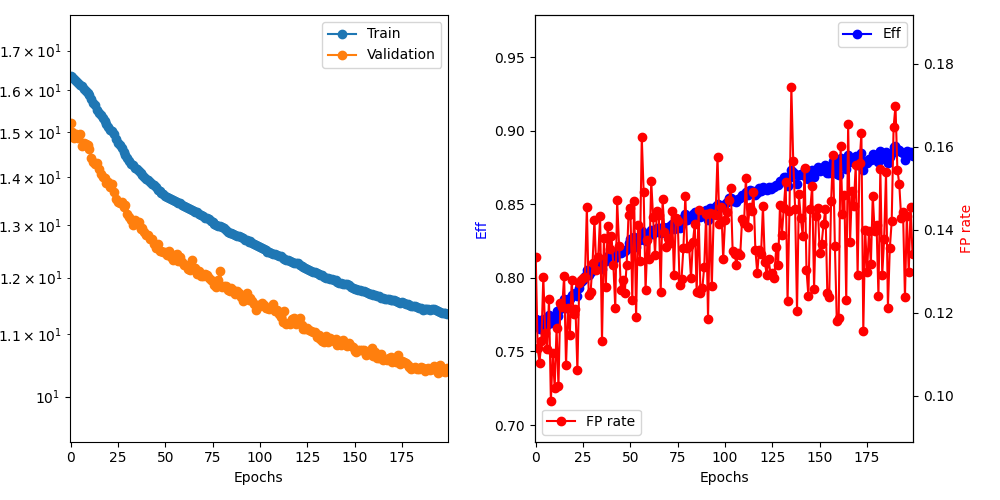

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1250, val = 78


Epoch 0: train=16.344, val=15.2104, took 29.033 s
  Validation Found 42088 of 54504, added 1333 (eff 77.22%) (0.134 FP/event)


Epoch 1: train=16.3196, val=14.9923, took 26.018 s
  Validation Found 41805 of 54504, added 1113 (eff 76.70%) (0.111 FP/event)


Epoch 2: train=16.2667, val=14.8722, took 25.413 s
  Validation Found 41704 of 54504, added 1078 (eff 76.52%) (0.108 FP/event)


Epoch 3: train=16.2268, val=14.9501, took 25.35 s
  Validation Found 41950 of 54504, added 1131 (eff 76.97%) (0.113 FP/event)


Epoch 4: train=16.1716, val=14.8629, took 25.271 s
  Validation Found 42091 of 54504, added 1284 (eff 77.23%) (0.129 FP/event)


Epoch 5: train=16.1264, val=14.9654, took 24.925 s
  Validation Found 42077 of 54504, added 1150 (eff 77.20%) (0.115 FP/event)


Epoch 6: train=16.0927, val=14.6817, took 25.169 s
  Validation Found 41856 of 54504, added 1111 (eff 76.79%) (0.111 FP/event)


Epoch 7: train=16.0306, val=14.7578, took 25.272 s
  Validation Found 42221 of 54504, added 1231 (eff 77.46%) (0.123 FP/event)


Epoch 8: train=15.9689, val=14.7365, took 25.115 s
  Validation Found 41939 of 54504, added 986 (eff 76.95%) (0.0987 FP/event)


Epoch 9: train=15.9351, val=14.7023, took 25.337 s
  Validation Found 42141 of 54504, added 1101 (eff 77.32%) (0.11 FP/event)


Epoch 10: train=15.8898, val=14.6233, took 25.076 s
  Validation Found 42052 of 54504, added 1017 (eff 77.15%) (0.102 FP/event)


Epoch 11: train=15.7757, val=14.424, took 25.071 s
  Validation Found 42366 of 54504, added 1161 (eff 77.73%) (0.116 FP/event)


Epoch 12: train=15.6899, val=14.3339, took 25.271 s
  Validation Found 42203 of 54504, added 1021 (eff 77.43%) (0.102 FP/event)


Epoch 13: train=15.6287, val=14.2849, took 26.848 s
  Validation Found 42456 of 54504, added 1222 (eff 77.90%) (0.122 FP/event)


Epoch 14: train=15.522, val=14.3087, took 25.64 s
  Validation Found 42663 of 54504, added 1213 (eff 78.27%) (0.121 FP/event)


Epoch 15: train=15.4533, val=14.1849, took 26.383 s
  Validation Found 42821 of 54504, added 1287 (eff 78.56%) (0.129 FP/event)


Epoch 16: train=15.3997, val=14.0767, took 25.53 s
  Validation Found 42491 of 54504, added 1071 (eff 77.96%) (0.107 FP/event)


Epoch 17: train=15.3182, val=13.9977, took 25.427 s
  Validation Found 42810 of 54504, added 1209 (eff 78.54%) (0.121 FP/event)


Epoch 18: train=15.2515, val=13.9796, took 25.259 s
  Validation Found 42817 of 54504, added 1145 (eff 78.56%) (0.115 FP/event)


Epoch 19: train=15.1853, val=13.8803, took 24.941 s
  Validation Found 42980 of 54504, added 1277 (eff 78.86%) (0.128 FP/event)


Epoch 20: train=15.1206, val=13.8886, took 25.177 s
  Validation Found 43010 of 54504, added 1195 (eff 78.91%) (0.12 FP/event)


Epoch 21: train=15.0576, val=13.7913, took 25.072 s
  Validation Found 43030 of 54504, added 1208 (eff 78.95%) (0.121 FP/event)


Epoch 22: train=15.0179, val=13.8532, took 24.873 s
  Validation Found 42938 of 54504, added 1060 (eff 78.78%) (0.106 FP/event)


Epoch 23: train=14.9535, val=13.6931, took 25.168 s
  Validation Found 43247 of 54504, added 1270 (eff 79.35%) (0.127 FP/event)


Epoch 24: train=14.846, val=13.537, took 24.899 s
  Validation Found 43440 of 54504, added 1278 (eff 79.70%) (0.128 FP/event)


Epoch 25: train=14.7561, val=13.4837, took 24.878 s
  Validation Found 43528 of 54504, added 1281 (eff 79.86%) (0.128 FP/event)


Epoch 26: train=14.7056, val=13.4638, took 24.899 s
  Validation Found 43659 of 54504, added 1283 (eff 80.10%) (0.128 FP/event)


Epoch 27: train=14.6436, val=13.4825, took 24.809 s
  Validation Found 43894 of 54504, added 1452 (eff 80.53%) (0.145 FP/event)


Epoch 28: train=14.5504, val=13.3747, took 25.051 s
  Validation Found 43720 of 54504, added 1240 (eff 80.21%) (0.124 FP/event)


Epoch 29: train=14.4812, val=13.4161, took 25.116 s
  Validation Found 43813 of 54504, added 1249 (eff 80.38%) (0.125 FP/event)


Epoch 30: train=14.4212, val=13.2336, took 24.936 s
  Validation Found 43936 of 54504, added 1318 (eff 80.61%) (0.132 FP/event)


Epoch 31: train=14.3524, val=13.1653, took 25.491 s
  Validation Found 44051 of 54504, added 1422 (eff 80.82%) (0.142 FP/event)


Epoch 32: train=14.2865, val=13.1175, took 25.148 s
  Validation Found 43987 of 54504, added 1302 (eff 80.70%) (0.13 FP/event)


Epoch 33: train=14.2529, val=13.018, took 24.982 s
  Validation Found 44116 of 54504, added 1332 (eff 80.94%) (0.133 FP/event)


Epoch 34: train=14.2052, val=13.108, took 25.569 s
  Validation Found 44249 of 54504, added 1431 (eff 81.18%) (0.143 FP/event)


Epoch 35: train=14.1816, val=13.0218, took 25.076 s
  Validation Found 43947 of 54504, added 1129 (eff 80.63%) (0.113 FP/event)


Epoch 36: train=14.1384, val=13.0607, took 24.854 s
  Validation Found 44289 of 54504, added 1378 (eff 81.26%) (0.138 FP/event)


Epoch 37: train=14.0949, val=12.9367, took 24.935 s
  Validation Found 44223 of 54504, added 1260 (eff 81.14%) (0.126 FP/event)


Epoch 38: train=14.0517, val=12.9438, took 24.761 s
  Validation Found 44432 of 54504, added 1408 (eff 81.52%) (0.141 FP/event)


Epoch 39: train=14.006, val=12.8695, took 24.966 s
  Validation Found 44441 of 54504, added 1352 (eff 81.54%) (0.135 FP/event)


Epoch 40: train=13.9666, val=12.818, took 25.276 s
  Validation Found 44504 of 54504, added 1383 (eff 81.65%) (0.139 FP/event)


Epoch 41: train=13.9347, val=12.812, took 25.033 s
  Validation Found 44485 of 54504, added 1313 (eff 81.62%) (0.131 FP/event)


Epoch 42: train=13.8862, val=12.7236, took 25.11 s
  Validation Found 44334 of 54504, added 1210 (eff 81.34%) (0.121 FP/event)


Epoch 43: train=13.8527, val=12.7377, took 25.214 s
  Validation Found 44605 of 54504, added 1469 (eff 81.84%) (0.147 FP/event)


Epoch 44: train=13.8221, val=12.6409, took 24.781 s
  Validation Found 44542 of 54504, added 1358 (eff 81.72%) (0.136 FP/event)


Epoch 45: train=13.7801, val=12.563, took 24.822 s
  Validation Found 44514 of 54504, added 1252 (eff 81.67%) (0.125 FP/event)


Epoch 46: train=13.73, val=12.6301, took 25.084 s
  Validation Found 44596 of 54504, added 1276 (eff 81.82%) (0.128 FP/event)


Epoch 47: train=13.6982, val=12.4949, took 24.796 s
  Validation Found 44599 of 54504, added 1245 (eff 81.83%) (0.125 FP/event)


Epoch 48: train=13.664, val=12.5079, took 24.839 s
  Validation Found 44687 of 54504, added 1313 (eff 81.99%) (0.131 FP/event)


Epoch 49: train=13.6364, val=12.4894, took 24.897 s
  Validation Found 44896 of 54504, added 1434 (eff 82.37%) (0.144 FP/event)


Epoch 50: train=13.5995, val=12.4902, took 24.607 s
  Validation Found 45039 of 54504, added 1451 (eff 82.63%) (0.145 FP/event)


Epoch 51: train=13.5701, val=12.4332, took 24.849 s
  Validation Found 44787 of 54504, added 1228 (eff 82.17%) (0.123 FP/event)


Epoch 52: train=13.5507, val=12.4955, took 24.885 s
  Validation Found 45122 of 54504, added 1467 (eff 82.79%) (0.147 FP/event)


Epoch 53: train=13.5386, val=12.3846, took 24.548 s
  Validation Found 44761 of 54504, added 1188 (eff 82.12%) (0.119 FP/event)


Epoch 54: train=13.515, val=12.3314, took 24.774 s
  Validation Found 45034 of 54504, added 1409 (eff 82.63%) (0.141 FP/event)


Epoch 55: train=13.4964, val=12.4251, took 25.096 s
  Validation Found 44996 of 54504, added 1322 (eff 82.56%) (0.132 FP/event)


Epoch 56: train=13.4707, val=12.4493, took 24.534 s
  Validation Found 45340 of 54504, added 1621 (eff 83.19%) (0.162 FP/event)


Epoch 57: train=13.46, val=12.3174, took 24.812 s
  Validation Found 45175 of 54504, added 1489 (eff 82.88%) (0.149 FP/event)


Epoch 58: train=13.4495, val=12.3933, took 24.791 s
  Validation Found 44953 of 54504, added 1252 (eff 82.48%) (0.125 FP/event)


Epoch 59: train=13.4188, val=12.2916, took 24.501 s
  Validation Found 45157 of 54504, added 1373 (eff 82.85%) (0.138 FP/event)


Epoch 60: train=13.4031, val=12.226, took 24.992 s
  Validation Found 45182 of 54504, added 1327 (eff 82.90%) (0.133 FP/event)


Epoch 61: train=13.372, val=12.2437, took 24.773 s
  Validation Found 45389 of 54504, added 1515 (eff 83.28%) (0.152 FP/event)


Epoch 62: train=13.3619, val=12.1662, took 24.427 s
  Validation Found 45237 of 54504, added 1429 (eff 83.00%) (0.143 FP/event)


Epoch 63: train=13.3382, val=12.1468, took 24.751 s
  Validation Found 45291 of 54504, added 1338 (eff 83.10%) (0.134 FP/event)


Epoch 64: train=13.3135, val=12.3284, took 24.738 s
  Validation Found 45445 of 54504, added 1444 (eff 83.38%) (0.145 FP/event)


Epoch 65: train=13.2984, val=12.1864, took 24.668 s
  Validation Found 45452 of 54504, added 1433 (eff 83.39%) (0.144 FP/event)


Epoch 66: train=13.2726, val=12.1868, took 25.059 s
  Validation Found 45274 of 54504, added 1248 (eff 83.07%) (0.125 FP/event)


Epoch 67: train=13.2615, val=12.0751, took 24.967 s
  Validation Found 45491 of 54504, added 1471 (eff 83.46%) (0.147 FP/event)


Epoch 68: train=13.2404, val=12.1142, took 25.383 s
  Validation Found 45443 of 54504, added 1392 (eff 83.38%) (0.139 FP/event)


Epoch 69: train=13.2099, val=12.026, took 25.602 s
  Validation Found 45393 of 54504, added 1356 (eff 83.28%) (0.136 FP/event)


Epoch 70: train=13.1852, val=12.0294, took 25.394 s
  Validation Found 45476 of 54504, added 1378 (eff 83.44%) (0.138 FP/event)


Epoch 71: train=13.1581, val=12.0694, took 24.866 s
  Validation Found 45515 of 54504, added 1365 (eff 83.51%) (0.137 FP/event)


Epoch 72: train=13.1441, val=12.0537, took 24.888 s
  Validation Found 45585 of 54504, added 1444 (eff 83.64%) (0.145 FP/event)


Epoch 73: train=13.1306, val=11.9975, took 24.567 s
  Validation Found 45412 of 54504, added 1288 (eff 83.32%) (0.129 FP/event)


Epoch 74: train=13.0979, val=11.9627, took 24.847 s
  Validation Found 45679 of 54504, added 1426 (eff 83.81%) (0.143 FP/event)


Epoch 75: train=13.0688, val=11.9443, took 25.089 s
  Validation Found 45711 of 54504, added 1419 (eff 83.87%) (0.142 FP/event)


Epoch 76: train=13.0316, val=11.8735, took 24.876 s
  Validation Found 45463 of 54504, added 1265 (eff 83.41%) (0.127 FP/event)


Epoch 77: train=13.0142, val=11.8275, took 25.086 s
  Validation Found 45610 of 54504, added 1280 (eff 83.68%) (0.128 FP/event)


Epoch 78: train=12.9941, val=11.9544, took 25.198 s
  Validation Found 45831 of 54504, added 1354 (eff 84.09%) (0.136 FP/event)


Epoch 79: train=12.9796, val=12.1162, took 24.855 s
  Validation Found 45956 of 54504, added 1479 (eff 84.32%) (0.148 FP/event)


Epoch 80: train=12.97, val=11.828, took 24.928 s
  Validation Found 45737 of 54504, added 1353 (eff 83.91%) (0.136 FP/event)


Epoch 81: train=12.94, val=11.8459, took 25.165 s
  Validation Found 45875 of 54504, added 1359 (eff 84.17%) (0.136 FP/event)


Epoch 82: train=12.9047, val=11.8467, took 24.875 s
  Validation Found 45813 of 54504, added 1281 (eff 84.05%) (0.128 FP/event)


Epoch 83: train=12.8713, val=11.7763, took 24.874 s
  Validation Found 45987 of 54504, added 1368 (eff 84.37%) (0.137 FP/event)


Epoch 84: train=12.8591, val=11.7577, took 24.808 s
  Validation Found 46048 of 54504, added 1412 (eff 84.49%) (0.141 FP/event)


Epoch 85: train=12.8417, val=11.8166, took 24.832 s
  Validation Found 45854 of 54504, added 1249 (eff 84.13%) (0.125 FP/event)


Epoch 86: train=12.8345, val=11.7775, took 25.155 s
  Validation Found 46057 of 54504, added 1445 (eff 84.50%) (0.145 FP/event)


Epoch 87: train=12.8179, val=11.7074, took 25.121 s
  Validation Found 45866 of 54504, added 1245 (eff 84.15%) (0.125 FP/event)


Epoch 88: train=12.7973, val=11.7531, took 24.739 s
  Validation Found 45906 of 54504, added 1258 (eff 84.23%) (0.126 FP/event)


Epoch 89: train=12.7863, val=11.7245, took 25.025 s
  Validation Found 46019 of 54504, added 1309 (eff 84.43%) (0.131 FP/event)


Epoch 90: train=12.7709, val=11.6555, took 24.783 s
  Validation Found 46125 of 54504, added 1435 (eff 84.63%) (0.144 FP/event)


Epoch 91: train=12.7488, val=11.5826, took 24.672 s
  Validation Found 45761 of 54504, added 1184 (eff 83.96%) (0.119 FP/event)


Epoch 92: train=12.7228, val=11.6092, took 24.96 s
  Validation Found 46200 of 54504, added 1438 (eff 84.76%) (0.144 FP/event)


Epoch 93: train=12.707, val=11.7158, took 25.666 s
  Validation Found 45971 of 54504, added 1262 (eff 84.34%) (0.126 FP/event)


Epoch 94: train=12.6812, val=11.5914, took 24.82 s
  Validation Found 46209 of 54504, added 1436 (eff 84.78%) (0.144 FP/event)


Epoch 95: train=12.6876, val=11.6253, took 25.016 s
  Validation Found 46263 of 54504, added 1434 (eff 84.88%) (0.144 FP/event)


Epoch 96: train=12.6624, val=11.5757, took 24.776 s
  Validation Found 46347 of 54504, added 1574 (eff 85.03%) (0.158 FP/event)


Epoch 97: train=12.6328, val=11.5322, took 24.707 s
  Validation Found 46214 of 54504, added 1412 (eff 84.79%) (0.141 FP/event)


Epoch 98: train=12.6168, val=11.4267, took 24.976 s
  Validation Found 46234 of 54504, added 1453 (eff 84.83%) (0.146 FP/event)


Epoch 99: train=12.5966, val=11.5104, took 24.702 s
  Validation Found 46235 of 54504, added 1327 (eff 84.83%) (0.133 FP/event)


Epoch 100: train=12.5724, val=11.4983, took 24.765 s
  Validation Found 46345 of 54504, added 1421 (eff 85.03%) (0.142 FP/event)


Epoch 101: train=12.5543, val=11.5499, took 24.952 s
  Validation Found 46419 of 54504, added 1440 (eff 85.17%) (0.144 FP/event)


Epoch 102: train=12.5341, val=11.5047, took 24.618 s
  Validation Found 46565 of 54504, added 1469 (eff 85.43%) (0.147 FP/event)


Epoch 103: train=12.5104, val=11.4543, took 24.795 s
  Validation Found 46548 of 54504, added 1498 (eff 85.40%) (0.15 FP/event)


Epoch 104: train=12.4878, val=11.4482, took 24.946 s
  Validation Found 46446 of 54504, added 1346 (eff 85.22%) (0.135 FP/event)


Epoch 105: train=12.4766, val=11.4311, took 24.627 s
  Validation Found 46476 of 54504, added 1340 (eff 85.27%) (0.134 FP/event)


Epoch 106: train=12.4531, val=11.4572, took 24.803 s
  Validation Found 46422 of 54504, added 1314 (eff 85.17%) (0.132 FP/event)


Epoch 107: train=12.4516, val=11.519, took 24.928 s
  Validation Found 46509 of 54504, added 1342 (eff 85.33%) (0.134 FP/event)


Epoch 108: train=12.439, val=11.3935, took 24.592 s
  Validation Found 46556 of 54504, added 1338 (eff 85.42%) (0.134 FP/event)


Epoch 109: train=12.4278, val=11.422, took 24.873 s
  Validation Found 46662 of 54504, added 1424 (eff 85.61%) (0.143 FP/event)


Epoch 110: train=12.4098, val=11.3458, took 24.893 s
  Validation Found 46642 of 54504, added 1413 (eff 85.58%) (0.142 FP/event)


Epoch 111: train=12.4068, val=11.2918, took 24.626 s
  Validation Found 46785 of 54504, added 1523 (eff 85.84%) (0.153 FP/event)


Epoch 112: train=12.3766, val=11.2193, took 24.938 s
  Validation Found 46683 of 54504, added 1404 (eff 85.65%) (0.141 FP/event)


Epoch 113: train=12.3516, val=11.3957, took 24.869 s
  Validation Found 46858 of 54504, added 1452 (eff 85.97%) (0.145 FP/event)


Epoch 114: train=12.3273, val=11.1705, took 24.621 s
  Validation Found 46771 of 54504, added 1443 (eff 85.81%) (0.145 FP/event)


Epoch 115: train=12.3233, val=11.1901, took 24.959 s
  Validation Found 46830 of 54504, added 1489 (eff 85.92%) (0.149 FP/event)


Epoch 116: train=12.3095, val=11.1838, took 24.806 s
  Validation Found 46677 of 54504, added 1350 (eff 85.64%) (0.135 FP/event)


Epoch 117: train=12.2932, val=11.2645, took 24.647 s
  Validation Found 46748 of 54504, added 1294 (eff 85.77%) (0.13 FP/event)


Epoch 118: train=12.2812, val=11.2816, took 24.917 s
  Validation Found 46931 of 54504, added 1349 (eff 86.11%) (0.135 FP/event)


Epoch 119: train=12.2702, val=11.1777, took 24.772 s
  Validation Found 46834 of 54504, added 1340 (eff 85.93%) (0.134 FP/event)


Epoch 120: train=12.2647, val=11.2183, took 24.675 s
  Validation Found 46965 of 54504, added 1454 (eff 86.17%) (0.146 FP/event)


Epoch 121: train=12.239, val=11.2839, took 24.947 s
  Validation Found 46913 of 54504, added 1320 (eff 86.07%) (0.132 FP/event)


Epoch 122: train=12.2231, val=11.1635, took 24.714 s
  Validation Found 46860 of 54504, added 1289 (eff 85.98%) (0.129 FP/event)


Epoch 123: train=12.1942, val=11.0897, took 24.762 s
  Validation Found 46970 of 54504, added 1327 (eff 86.18%) (0.133 FP/event)


Epoch 124: train=12.1729, val=11.0924, took 24.977 s
  Validation Found 46898 of 54504, added 1291 (eff 86.05%) (0.129 FP/event)


Epoch 125: train=12.1592, val=11.1129, took 24.695 s
  Validation Found 46961 of 54504, added 1294 (eff 86.16%) (0.13 FP/event)


Epoch 126: train=12.1392, val=11.0803, took 24.976 s
  Validation Found 46966 of 54504, added 1281 (eff 86.17%) (0.128 FP/event)


Epoch 127: train=12.1173, val=11.0568, took 25.168 s
  Validation Found 47061 of 54504, added 1356 (eff 86.34%) (0.136 FP/event)


Epoch 128: train=12.1075, val=11.0371, took 24.857 s
  Validation Found 47038 of 54504, added 1313 (eff 86.30%) (0.131 FP/event)


Epoch 129: train=12.1022, val=11.0355, took 25.026 s
  Validation Found 47204 of 54504, added 1457 (eff 86.61%) (0.146 FP/event)


Epoch 130: train=12.0863, val=10.9599, took 25.165 s
  Validation Found 47204 of 54504, added 1386 (eff 86.61%) (0.139 FP/event)


Epoch 131: train=12.0687, val=10.9971, took 24.832 s
  Validation Found 47330 of 54504, added 1451 (eff 86.84%) (0.145 FP/event)


Epoch 132: train=12.0412, val=10.9231, took 24.801 s
  Validation Found 47360 of 54504, added 1514 (eff 86.89%) (0.152 FP/event)


Epoch 133: train=12.0436, val=10.8962, took 24.903 s
  Validation Found 47001 of 54504, added 1226 (eff 86.23%) (0.123 FP/event)


Epoch 134: train=12.0181, val=10.868, took 24.509 s
  Validation Found 47297 of 54504, added 1444 (eff 86.78%) (0.145 FP/event)


Epoch 135: train=11.9999, val=10.9719, took 24.771 s
  Validation Found 47616 of 54504, added 1741 (eff 87.36%) (0.174 FP/event)


Epoch 136: train=11.9869, val=10.8695, took 24.829 s
  Validation Found 47532 of 54504, added 1564 (eff 87.21%) (0.157 FP/event)


Epoch 137: train=11.972, val=10.9386, took 24.804 s
  Validation Found 47440 of 54504, added 1449 (eff 87.04%) (0.145 FP/event)


Epoch 138: train=11.9669, val=10.9087, took 24.917 s
  Validation Found 47099 of 54504, added 1202 (eff 86.41%) (0.12 FP/event)


Epoch 139: train=11.9577, val=10.8832, took 24.817 s
  Validation Found 47414 of 54504, added 1483 (eff 86.99%) (0.149 FP/event)


Epoch 140: train=11.9533, val=10.9167, took 24.626 s
  Validation Found 47451 of 54504, added 1425 (eff 87.06%) (0.143 FP/event)


Epoch 141: train=11.9257, val=10.8254, took 24.935 s
  Validation Found 47405 of 54504, added 1384 (eff 86.98%) (0.139 FP/event)


Epoch 142: train=11.9083, val=10.8832, took 24.823 s
  Validation Found 47642 of 54504, added 1546 (eff 87.41%) (0.155 FP/event)


Epoch 143: train=11.905, val=10.8153, took 24.804 s
  Validation Found 47335 of 54504, added 1301 (eff 86.85%) (0.13 FP/event)


Epoch 144: train=11.8909, val=10.9141, took 25.158 s
  Validation Found 47284 of 54504, added 1238 (eff 86.75%) (0.124 FP/event)


Epoch 145: train=11.8776, val=10.8353, took 25.074 s
  Validation Found 47533 of 54504, added 1447 (eff 87.21%) (0.145 FP/event)


Epoch 146: train=11.8777, val=10.7996, took 24.831 s
  Validation Found 47607 of 54504, added 1504 (eff 87.35%) (0.151 FP/event)


Epoch 147: train=11.8653, val=10.8485, took 25.268 s
  Validation Found 47328 of 54504, added 1256 (eff 86.83%) (0.126 FP/event)


Epoch 148: train=11.8333, val=10.811, took 25.062 s
  Validation Found 47575 of 54504, added 1431 (eff 87.29%) (0.143 FP/event)


Epoch 149: train=11.8085, val=10.7923, took 24.855 s
  Validation Found 47700 of 54504, added 1450 (eff 87.52%) (0.145 FP/event)


Epoch 150: train=11.7955, val=10.7225, took 25.163 s
  Validation Found 47572 of 54504, added 1343 (eff 87.28%) (0.135 FP/event)


Epoch 151: train=11.7876, val=10.7046, took 25.036 s
  Validation Found 47591 of 54504, added 1364 (eff 87.32%) (0.137 FP/event)


Epoch 152: train=11.7778, val=10.7446, took 24.682 s
  Validation Found 47718 of 54504, added 1412 (eff 87.55%) (0.141 FP/event)


Epoch 153: train=11.7729, val=10.7468, took 25.109 s
  Validation Found 47776 of 54504, added 1449 (eff 87.66%) (0.145 FP/event)


Epoch 154: train=11.7545, val=10.7324, took 24.751 s
  Validation Found 47484 of 54504, added 1246 (eff 87.12%) (0.125 FP/event)


Epoch 155: train=11.7515, val=10.7442, took 24.717 s
  Validation Found 47507 of 54504, added 1236 (eff 87.16%) (0.124 FP/event)


Epoch 156: train=11.7373, val=10.6545, took 24.948 s
  Validation Found 47745 of 54504, added 1467 (eff 87.60%) (0.147 FP/event)


Epoch 157: train=11.7298, val=10.6703, took 24.682 s
  Validation Found 47930 of 54504, added 1579 (eff 87.94%) (0.158 FP/event)


Epoch 158: train=11.7118, val=10.716, took 24.767 s
  Validation Found 47738 of 54504, added 1359 (eff 87.59%) (0.136 FP/event)


Epoch 159: train=11.7095, val=10.7811, took 24.972 s
  Validation Found 47450 of 54504, added 1179 (eff 87.06%) (0.118 FP/event)


Epoch 160: train=11.6933, val=10.6419, took 24.634 s
  Validation Found 47432 of 54504, added 1185 (eff 87.02%) (0.119 FP/event)


Epoch 161: train=11.6874, val=10.7043, took 24.815 s
  Validation Found 48048 of 54504, added 1600 (eff 88.15%) (0.16 FP/event)


Epoch 162: train=11.6636, val=10.6148, took 24.942 s
  Validation Found 47876 of 54504, added 1437 (eff 87.84%) (0.144 FP/event)


Epoch 163: train=11.6589, val=10.6149, took 24.624 s
  Validation Found 47984 of 54504, added 1482 (eff 88.04%) (0.148 FP/event)


Epoch 164: train=11.6372, val=10.6694, took 25.673 s
  Validation Found 47647 of 54504, added 1228 (eff 87.42%) (0.123 FP/event)


Epoch 165: train=11.6338, val=10.5744, took 25.637 s
  Validation Found 48158 of 54504, added 1653 (eff 88.36%) (0.166 FP/event)


Epoch 166: train=11.6212, val=10.6001, took 25.326 s
  Validation Found 47895 of 54504, added 1368 (eff 87.87%) (0.137 FP/event)


Epoch 167: train=11.6163, val=10.5843, took 25.61 s
  Validation Found 48038 of 54504, added 1492 (eff 88.14%) (0.149 FP/event)


Epoch 168: train=11.6087, val=10.6015, took 25.547 s
  Validation Found 48024 of 54504, added 1456 (eff 88.11%) (0.146 FP/event)


Epoch 169: train=11.5951, val=10.6215, took 25.346 s
  Validation Found 48121 of 54504, added 1554 (eff 88.29%) (0.156 FP/event)


Epoch 170: train=11.5873, val=10.5427, took 25.667 s
  Validation Found 47799 of 54504, added 1289 (eff 87.70%) (0.129 FP/event)


Epoch 171: train=11.5942, val=10.5824, took 25.448 s
  Validation Found 48145 of 54504, added 1559 (eff 88.33%) (0.156 FP/event)


Epoch 172: train=11.5782, val=10.5454, took 25.298 s
  Validation Found 48232 of 54504, added 1630 (eff 88.49%) (0.163 FP/event)


Epoch 173: train=11.5678, val=10.6505, took 25.517 s
  Validation Found 47608 of 54504, added 1155 (eff 87.35%) (0.116 FP/event)


Epoch 174: train=11.5483, val=10.5062, took 24.961 s
  Validation Found 47937 of 54504, added 1398 (eff 87.95%) (0.14 FP/event)


Epoch 175: train=11.5568, val=10.5649, took 24.854 s
  Validation Found 47864 of 54504, added 1297 (eff 87.82%) (0.13 FP/event)


Epoch 176: train=11.5473, val=10.55, took 24.974 s
  Validation Found 48020 of 54504, added 1394 (eff 88.10%) (0.14 FP/event)


Epoch 177: train=11.5311, val=10.5232, took 24.647 s
  Validation Found 47985 of 54504, added 1316 (eff 88.04%) (0.132 FP/event)


Epoch 178: train=11.5259, val=10.4958, took 24.868 s
  Validation Found 48183 of 54504, added 1480 (eff 88.40%) (0.148 FP/event)


Epoch 179: train=11.5044, val=10.4583, took 24.963 s
  Validation Found 48118 of 54504, added 1394 (eff 88.28%) (0.14 FP/event)


Epoch 180: train=11.4892, val=10.4381, took 25.445 s
  Validation Found 48146 of 54504, added 1410 (eff 88.33%) (0.141 FP/event)


Epoch 181: train=11.4851, val=10.4466, took 25.629 s
  Validation Found 47915 of 54504, added 1238 (eff 87.91%) (0.124 FP/event)


Epoch 182: train=11.481, val=10.4605, took 25.58 s
  Validation Found 48299 of 54504, added 1545 (eff 88.62%) (0.155 FP/event)


Epoch 183: train=11.4755, val=10.4241, took 25.328 s
  Validation Found 48006 of 54504, added 1289 (eff 88.08%) (0.129 FP/event)


Epoch 184: train=11.4563, val=10.4375, took 25.657 s
  Validation Found 48129 of 54504, added 1376 (eff 88.30%) (0.138 FP/event)


Epoch 185: train=11.4534, val=10.4602, took 25.502 s
  Validation Found 48284 of 54504, added 1536 (eff 88.59%) (0.154 FP/event)


Epoch 186: train=11.427, val=10.4533, took 25.434 s
  Validation Found 47867 of 54504, added 1210 (eff 87.82%) (0.121 FP/event)


Epoch 187: train=11.4433, val=10.3982, took 25.653 s
  Validation Found 48073 of 54504, added 1353 (eff 88.20%) (0.136 FP/event)


Epoch 188: train=11.4289, val=10.4365, took 25.37 s
  Validation Found 48242 of 54504, added 1418 (eff 88.51%) (0.142 FP/event)


Epoch 189: train=11.4327, val=10.4441, took 25.514 s
  Validation Found 48448 of 54504, added 1645 (eff 88.89%) (0.165 FP/event)


Epoch 190: train=11.4177, val=10.4206, took 25.674 s
  Validation Found 48495 of 54504, added 1696 (eff 88.98%) (0.17 FP/event)


Epoch 191: train=11.4293, val=10.4365, took 25.322 s
  Validation Found 48365 of 54504, added 1543 (eff 88.74%) (0.155 FP/event)


Epoch 192: train=11.4284, val=10.4764, took 25.582 s
  Validation Found 48332 of 54504, added 1508 (eff 88.68%) (0.151 FP/event)


Epoch 193: train=11.4172, val=10.4188, took 25.607 s
  Validation Found 48274 of 54504, added 1427 (eff 88.57%) (0.143 FP/event)


Epoch 194: train=11.4047, val=10.3677, took 25.334 s
  Validation Found 48240 of 54504, added 1440 (eff 88.51%) (0.144 FP/event)


Epoch 195: train=11.391, val=10.4966, took 25.656 s
  Validation Found 47984 of 54504, added 1235 (eff 88.04%) (0.124 FP/event)


Epoch 196: train=11.3743, val=10.3942, took 25.519 s
  Validation Found 48308 of 54504, added 1432 (eff 88.63%) (0.143 FP/event)


Epoch 197: train=11.3651, val=10.3952, took 25.023 s
  Validation Found 48161 of 54504, added 1295 (eff 88.36%) (0.13 FP/event)


Epoch 198: train=11.3625, val=10.3765, took 24.973 s
  Validation Found 48276 of 54504, added 1452 (eff 88.57%) (0.145 FP/event)


Epoch 199: train=11.3465, val=10.4478, took 24.792 s
  Validation Found 48133 of 54504, added 1339 (eff 88.31%) (0.134 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/goofit/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


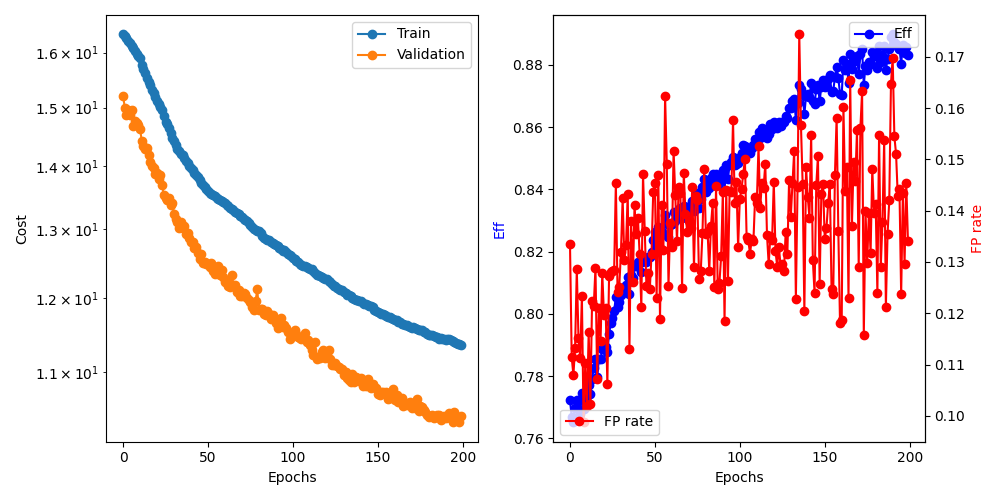

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
##quit()